# 콘크리트 강도를 예측하는 랜덤 포레스트 모델을 만들고 predict method를 이용하여 예측값을 구하라. 그리고 모델의 mse와 mae를 산출하여 비교하라..
데이터 : Concrete.CSV(변수: 9개, 자료 수: 1,030개)
 -.목표변수(Concrete_compressive_strength)
 
 ※ 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할 (train_test_split 활용)
 0. train_test_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
 1. train 데이터: 모델 훈련 
 2. validation 데이터: 최적의 parameter 찾기(과정의 [연습/실습]에서 test 데이터 역할)
 3. test 데이터: 2에서 찾은 최적의 parameter를 이용하여 만든 모델로 최종 성능 확인(단 한 번만 사용할 것)

In [1]:
# 랜덤포레스트 모델 생성에 필요한 라이브러리를 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
import statsmodels.formula.api as smf
from statsmodels.tools.eval_measures import rmse  # 추정의 표준오차
%matplotlib inline

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV   # cross validation(구버전)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics 

In [2]:
#Concrete.csv을 불러옴
df_raw = pd.read_csv("/home/pirl/Downloads/BigDataAnalysis/Concrete.csv", engine = "python")
df_raw.head()

,CEMENT,BLAST_FURNACE_SLAG,FLY_ASH,WATER,SUPERPLASTICIZER,COARSE_AGGREGATE,FINE_AGGREGATE,AGE,CONCRETE_COMPRESSIVE_STRENGTH
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [4]:
# 목표변수, 설명변수 데이터 지정
df_raw_y = df_raw["CONCRETE_COMPRESSIVE_STRENGTH"]
df_raw_x = df_raw.drop("CONCRETE_COMPRESSIVE_STRENGTH", axis= 1, inplace = False)

# train_set_split(x:설명변수 데이터, Y: 목표변수 데이터, test_size=test 데이터 비율, random_state: random seed)
# train_set_split 함수를 이용하여 데이터는 ( train(0.4) : validation(0.3) : test(0.3) )의 비율로 분할
# train_test_split 함수를 이용하여 train:test로 데이터 분할. 분할된 train 데이터를 재 분할하여 validation 데이터로 사용
#random state=8로 지정하여 입력 데이터 고정df_train_x, df_rest_x, df_train_y, df_rest_y= train_test_split(df_raw_x, df_raw_y, test_size=0.6, random_state=8)
df_train_x, df_rest_x, df_train_y, df_rest_y= train_test_split(df_raw_x, df_raw_y, test_size=0.6, random_state=87)
df_validation_x, df_test_x, df_validation_y, df_test_y= train_test_split(df_rest_x, df_rest_y, test_size=0.5, random_state=87)

print("train data X size:{}".format(df_train_x.shape))
print("train data Y size:{}".format(df_train_y.shape))
print("validation data X size:{}".format(df_validation_x.shape))
print("validation data Y size:{}".format(df_validation_y.shape))
print("test data X size:{}".format(df_test_x.shape))
print("test data Y size:{}".format(df_test_y.shape))

train data X size:(412, 8)
train data Y size:(412,)
validation data X size:(309, 8)
validation data Y size:(309,)
test data X size:(309, 8)
test data Y size:(309,)


In [8]:
# RandomForestRegressor을 이용하여 랜덤포레스트 모델 생성
# RandomForestRegressor import할 때 RFR로 줄여줌
rf_uncustomized = RFR(random_state = 85345)
rf_uncustomized.fit(df_train_x,df_train_y)
# Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))
# test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))

Score on training set: 0.974
Score on test set: 0.869


/home/pirl/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [9]:
# 랜덤 포레스트 - 모델 parameter 조정
# para_n_tree 값을  10~300까지 조정하면서 TrainScore, ValidationScore 값 출력
train_score = []; validation_score = []
para_n_tree = [n_tree * 10 for n_tree in range(1,31)]

for v_n_estimators in para_n_tree:
    rf = RFR(n_estimators=v_n_estimators, random_state=85345)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_validation_x, df_validation_y))
  
# 각 para_n_tree 수에 따른 TrainScore와 ValidationScore을 각 변수에 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"] = para_n_tree
df_score_n["TrainScore"] = train_score
df_score_n["ValidationScore"] = validation_score

In [10]:
# 각 para_n_tree 수에 따른 TrainScore와 ValidationScore을 내림차순으로 출력
df_score_n.round(3)

,n_estimators,TrainScore,ValidationScore
0,10,0.974,0.851
1,20,0.979,0.862
2,30,0.980,0.861
3,40,0.981,0.859
4,50,0.981,0.864
5,60,0.982,0.866
6,70,0.982,0.866
7,80,0.982,0.866
8,90,0.982,0.866
9,100,0.982,0.866


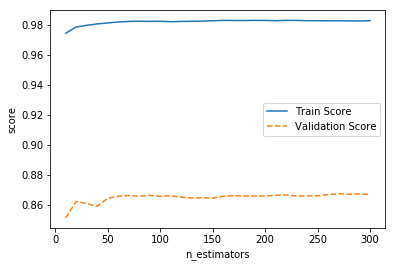

In [11]:
# 위의 값을 그래프로 출력
plt.plot(para_n_tree, train_score, linestyle="-", label="Train Score")
plt.plot(para_n_tree, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score"); plt.xlabel("n_estimators")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 n_estimators 선정 = 300

In [12]:
# n_estimators = 300을 고정하고, para_leaf를 1~20으로 조정하면서 잎사귀 노드의 최소 자료 수 도출
train_score = []; validation_score = []
para_leaf = [n_leaf * 1 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(n_estimators=300, random_state=85345, min_samples_leaf=v_min_samples_leaf)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_validation_x, df_validation_y))

# para_leaf에 따른 TrainScore, ValidationScore 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"] = para_leaf
df_score_leaf["TrainScore"] = train_score
df_score_leaf["ValidationScore"] = validation_score

df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,ValidationScore
0,1,0.983,0.867
1,2,0.969,0.860
2,3,0.955,0.851
3,4,0.941,0.841
4,5,0.926,0.832
5,6,0.913,0.822
6,7,0.900,0.814
7,8,0.887,0.806
8,9,0.876,0.799
9,10,0.865,0.792


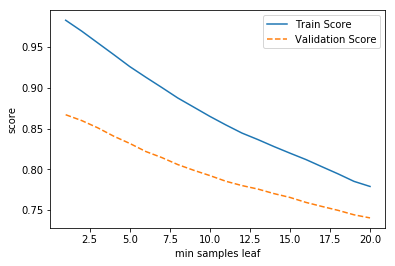

In [13]:
# 위의 값을 그래프로 출력
plt.plot(para_leaf, train_score, linestyle="-", label="Train Score")
plt.plot(para_leaf, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score"); plt.xlabel("min samples leaf")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 MinSamplesLeaf 선정 = 5

In [14]:
# n_estimators=200, min_samples_leaf=4을 고정하고, para_split가 4~40으로 변할 때 TrainScore, TestScore값 도출
train_score = []; validation_score = []
para_split = [n_split * 2 for n_split in range(5,21)]

for v_min_samples_split in para_split :
    rf = RFR(n_estimators=300, random_state=85345, min_samples_leaf = 5, min_samples_split = v_min_samples_split)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_validation_x, df_validation_y))
    
df_score_split= pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = validation_score

df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,10,0.926,0.832
1,12,0.921,0.829
2,14,0.914,0.823
3,16,0.907,0.820
4,18,0.899,0.814
5,20,0.891,0.808
6,22,0.884,0.802
7,24,0.877,0.798
8,26,0.870,0.793
9,28,0.863,0.788


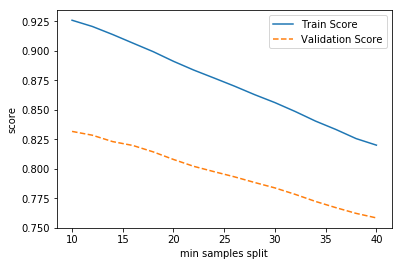

In [15]:
# 위의 값을 그래프로 출력
plt.plot(para_split, train_score, linestyle="-", label="Train Score")
plt.plot(para_split, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score"); plt.xlabel("min samples split")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 min samples split 선정 = 12

In [16]:
# n_estimators=200, min_samples_leaf=4, min_samples_split = 12을 고정하고, depth가 4~11으로 변할 때 TrainScore, TestScore값 도출
train_score = []; validation_score = []
para_depth = [depth for depth in range(4,11)]

for v_max_depth in para_depth :
    rf = RFR(n_estimators=300, random_state=85345, min_samples_leaf= 5, min_samples_split = 12, max_depth = v_max_depth)
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x, df_train_y))
    validation_score.append(rf.score(df_validation_x, df_validation_y))
    
df_score_depth = pd.DataFrame()
df_score_depth["Depth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["ValidationScore"] = validation_score

df_score_depth.round(3)

,Depth,TrainScore,ValidationScore
0,4,0.838,0.762
1,5,0.884,0.802
2,6,0.905,0.819
3,7,0.915,0.825
4,8,0.919,0.827
5,9,0.920,0.828
6,10,0.921,0.829


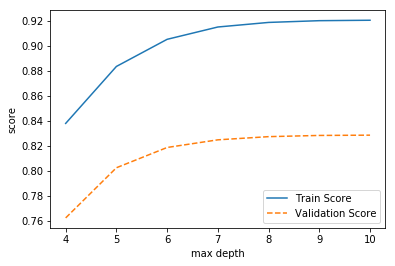

In [21]:
# 위의 값을 그래프로 출력
plt.plot(para_depth, train_score, linestyle="-", label="Train Score")
plt.plot(para_depth, validation_score, linestyle="--", label="Validation Score")
plt.ylabel("score"); plt.xlabel("max depth")
plt.legend()
# 차이가 가장 적으면서, 전체적으로 score가 높은 Depth 선정 = 7

In [42]:
# 최종 랜덤포레스트 모델 생성

rf_final = RFR(n_estimators=300, random_state=85345, min_samples_leaf= 5, min_samples_split = 12, max_depth = 6)
rf_final.fit(df_train_x, df_train_y)
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on validation set: {:.3f}".format(rf_final.score(df_validation_x, df_validation_y)))
rf_final

Score on training set: 0.905
Score on validation set: 0.819


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=85345, verbose=0,
           warm_start=False)

In [43]:
# test set으로 확인!

rf_final = RFR(n_estimators=300, random_state=85345, min_samples_leaf= 5, min_samples_split = 12, max_depth = 6)
rf_final.fit(df_train_x, df_train_y)

print("Score on training set: {:.3f}".format(rf_final.score(df_train_x, df_train_y)))
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x, df_test_y)))
rf_final
# test set 검증 결과 0.841

Score on training set: 0.905
Score on test set: 0.841


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=12,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=None,
           oob_score=False, random_state=85345, verbose=0,
           warm_start=False)

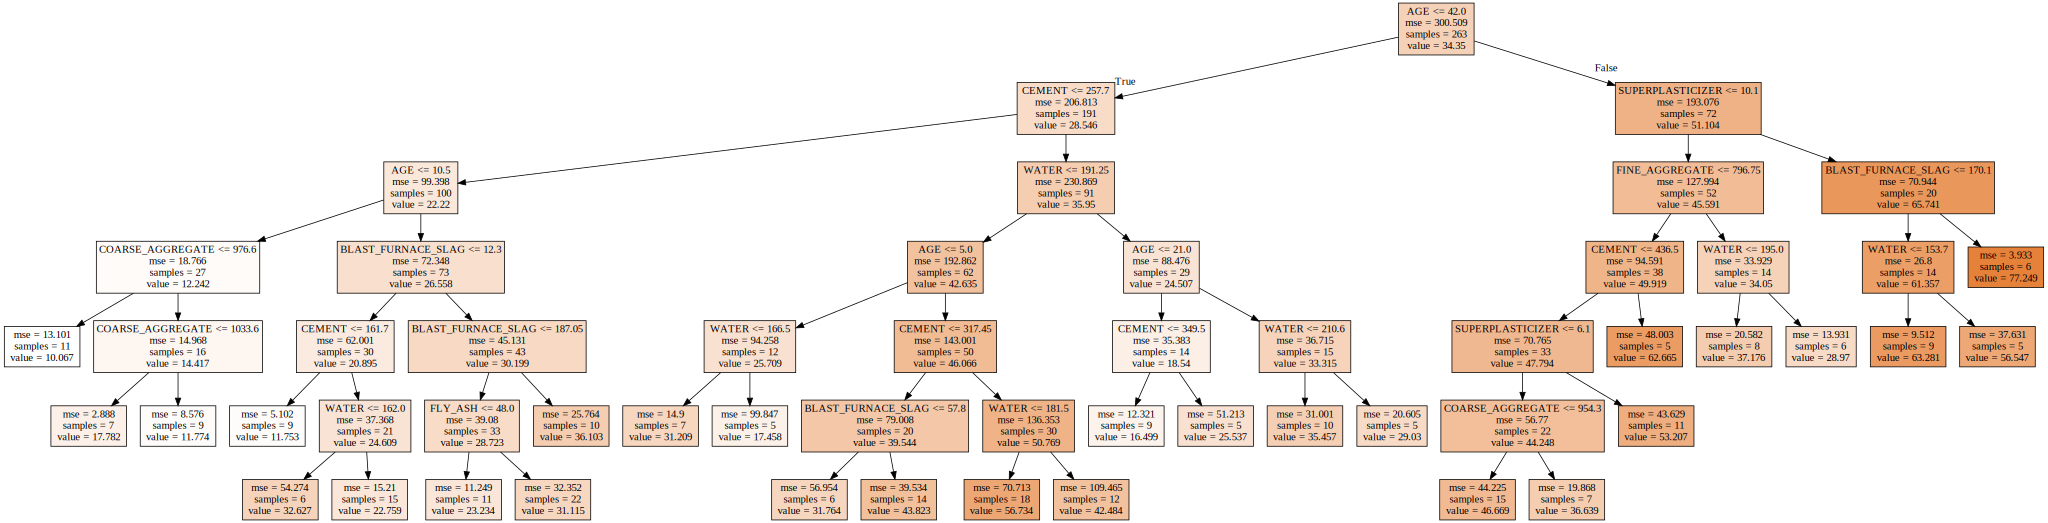

In [33]:
# 랜덤 포레스트 모델의 개별 트리
v_feature_name = df_train_x.columns
export_graphviz(rf_final.estimators_[0], out_file="rfr_final_0.dot",feature_names=v_feature_name, impurity=True, filled=True)

with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

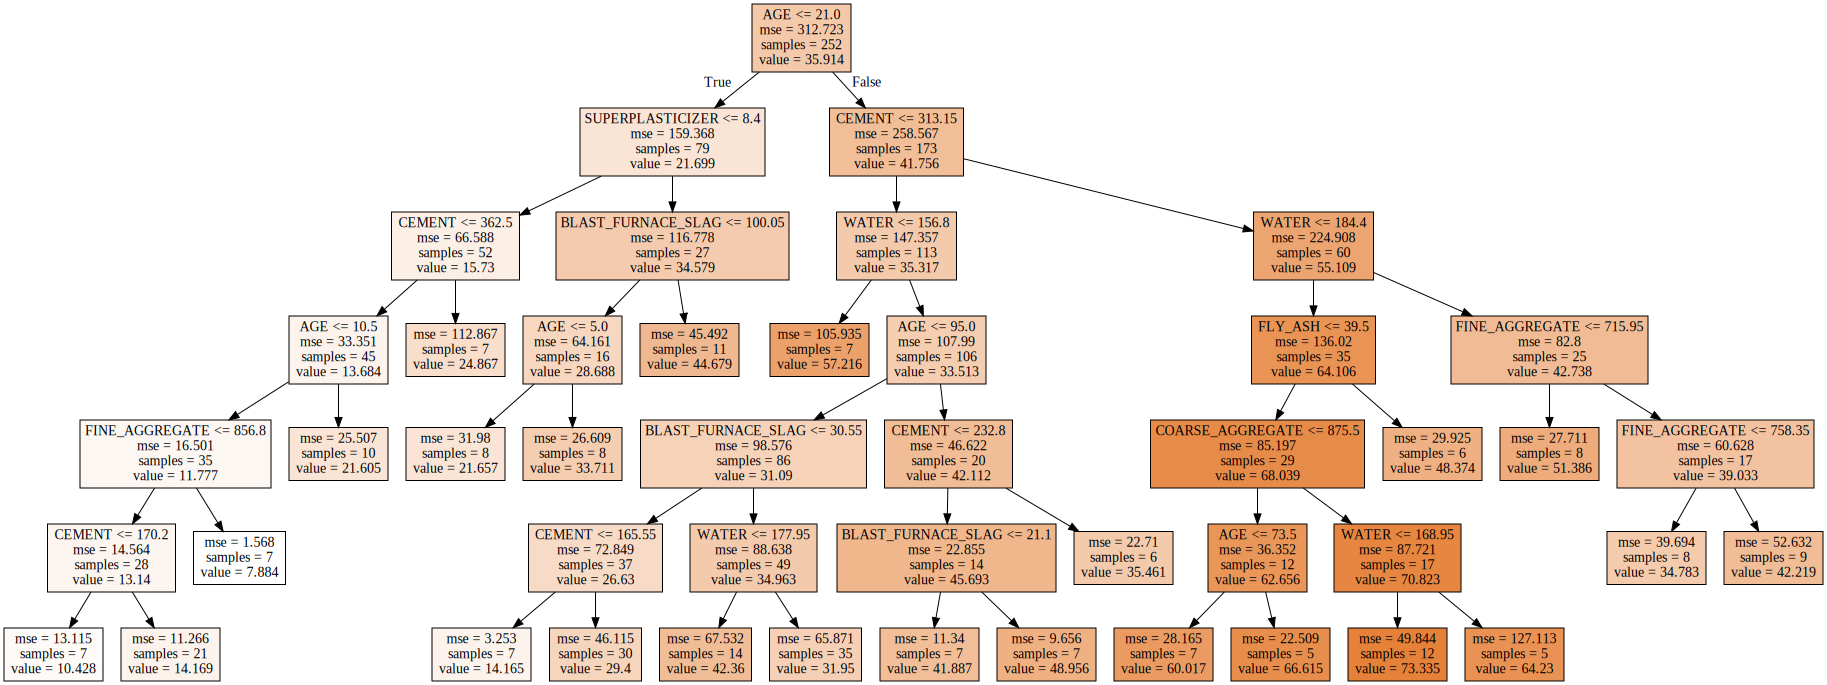

In [34]:
# 랜덤 포레스트 모델의 개별 트리
export_graphviz(rf_final.estimators_[1], out_file="rfr_final_1.dot",feature_names=v_feature_name, impurity=True, filled=True)

with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

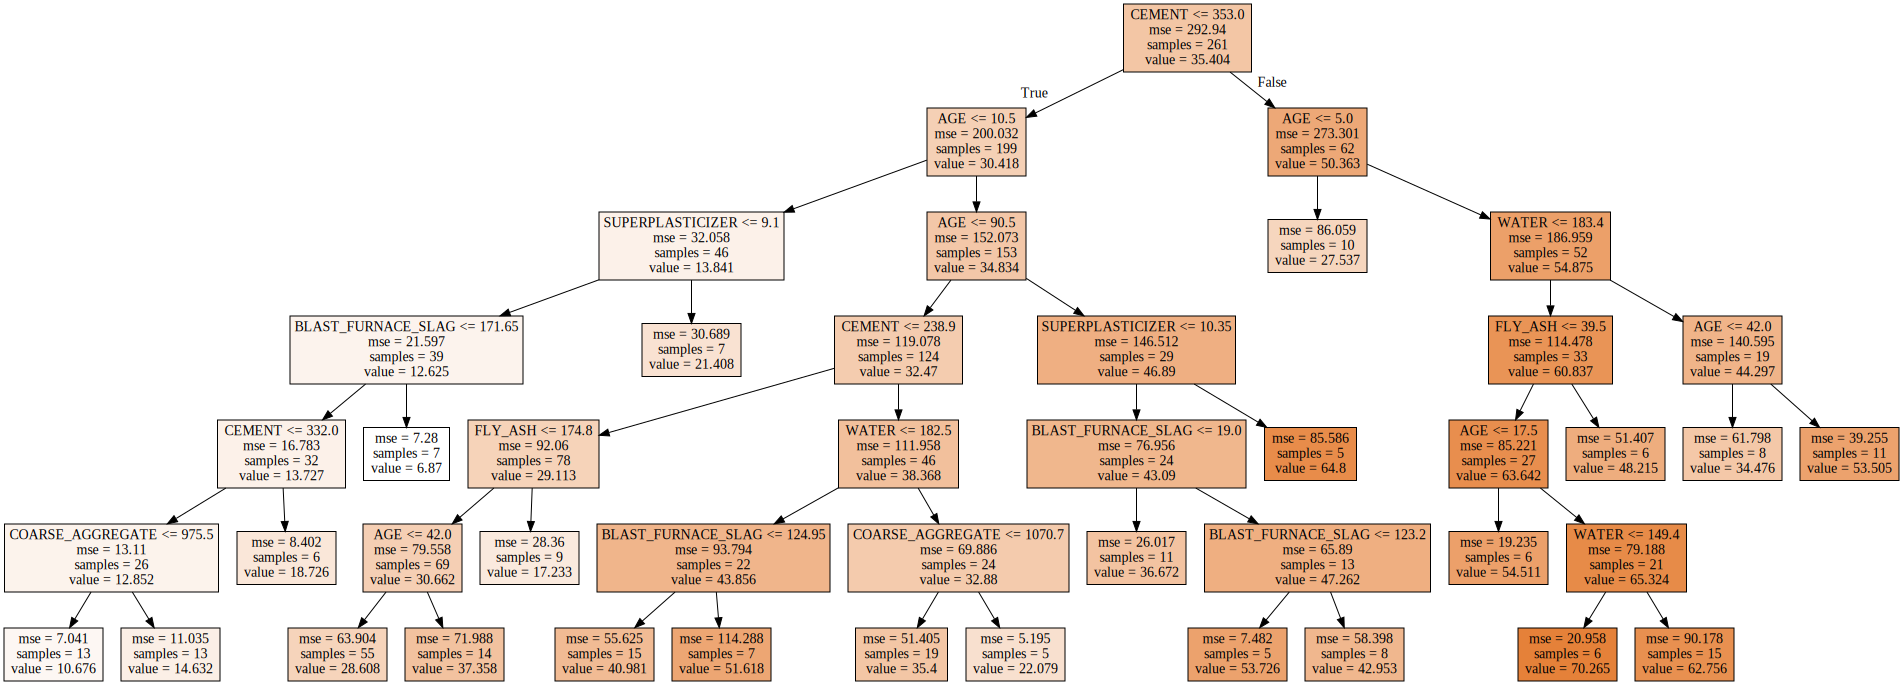

In [35]:
# 랜덤 포레스트 모델의 개별 트리
export_graphviz(rf_final.estimators_[10], out_file="rfr_final_10.dot",feature_names=v_feature_name, impurity=True, filled=True)

with open("rfr_final_10.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [36]:
# 각 설명변수의 변수 중요도 값
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"]=rf_final.feature_importances_

df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,AGE,0.406
0,CEMENT,0.255
4,SUPERPLASTICIZER,0.118
3,WATER,0.102
1,BLAST_FURNACE_SLAG,0.046
6,FINE_AGGREGATE,0.041
2,FLY_ASH,0.016
5,COARSE_AGGREGATE,0.015


Text(0, 0.5, '변수')

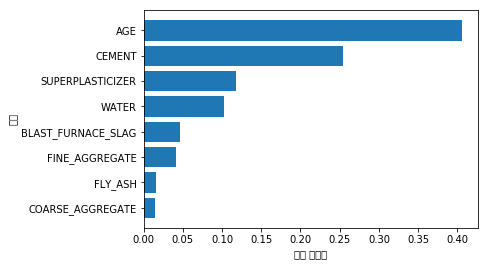

In [37]:
# 각 설명변수의 변수 중요도 값 그래프로 출력

df_importance.sort_values("Importance",ascending = True, inplace = True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

In [39]:
#모델의 mse와 mae를 산출하여 비교

rf_MSE = RFR(n_estimators=300, random_state=85345, min_samples_leaf= 5, min_samples_split = 12, max_depth = 6)
rf_MSE.fit(df_train_x, df_train_y)

rf_MAE = RFR(criterion="mae",n_estimators=300, random_state=85345, min_samples_leaf= 5, min_samples_split = 12, max_depth = 6)
rf_MAE.fit(df_train_x, df_train_y)

# 예측값과 실제값의 비교
y_pred = rf_MSE.predict(df_train_x)
df_comparison = pd.DataFrame()
df_comparison["y_predicted"] = y_pred
df_comparison["y_real"]= df_raw_y

df_comparison.round(3)

,y_predicted,y_real
0,40.824,79.99
1,55.238,61.89
2,25.178,40.27
3,45.053,41.05
4,27.059,44.30
5,41.829,47.03
6,42.148,43.70
7,28.036,36.45
8,26.320,45.85
9,61.874,39.29


In [41]:
# 모델의 mse와 mae 

mse = mean_squared_error(df_train_y, y_pred)
mae = mean_absolute_error(df_train_y, y_pred)
print("MSE :",mse.round(4))
print("MAE :",mae.round(4))

MSE : 27.3589
MAE : 4.0321


# 랜덤 포레스트 모델 시각화 및 해석
# : 트리에 영향이 큰 변수는 AGE, CEMENT, SUPERPLASTICIZER 등이다.
# AGE <= 42.0이면 True(자료 수=190, CONCRETE_COMPRESSIVE_STRENGTH가 34.582에서 28.891로 감소하고 MSE는 감소), AGE > 42.0이면 False(자료 수=78, CONCRETE_COMPRESSIVE_STRENGTH가 35.967에서 49.279로증가하고 MSE는 감소)로 분리한다.
# 그 이후에도 분리 조건을 만족하면 좌측, 만족하지 않으면 우측으로 내려가서 최종 리프를 찾는다.
# 위의 의사결정나무 모델 도출 결과 학습 데이터로는 91.0%, validation 데이터로 parameter들을 조정한 결과 82.1%의 정확도를 보였다.
# 또한 최종 test 데이터를 적용해봤을 때에 정확도는 84.1%로 다소 증가하였다.
# 의사결정트리 모델과 비교해 봤을 때, 비교적 높은 정확도를 가지고 있다.
# 그러나, 역시 건축물의 재료로 쓰이는 콘크리트의 강도를 측정할 때 쓰기에는 안전에 관련되어 있으므로 84.1%의 값도 신뢰성이 상당히 떨어진다.
# 따라서 이 모델은 쓰지 않는 것이 좋다고 판단된다.